In [1]:
import numpy as np
import corner
import matplotlib.pyplot as plt
import scipy.stats as stats
from tqdm import tqdm
import os
import matplotlib.gridspec as gridspec

import fit_time_dep_fluxes as fit_flux

import matplotlib
#matplotlib.rc('text',usetex=True)
font = {'family' : 'serif',
#        'weight' : 'bold',
        'size'   : 16,}
matplotlib.rc('font', **font)


In [2]:
plotpath = './figures/'
if not os.path.isdir(plotpath):
    os.makedirs(plotpath)


In [3]:
#generate some synthetic data

np.random.seed(104)

n_reads = 33
n_pixels = 100

#define the true multiplicative factor to the fluxes
true_b_vect = np.ones(n_reads-1)*1.0
true_b_vect = np.linspace(0.5,2.0,n_reads-1)
true_b_vect[n_reads//2:] = 1.0
true_b_vect /= true_b_vect.max()

true_b_vect = 1.0 - (np.random.rand(n_reads-1))*0.5

#define true fluxes in each pixel
true_fluxes = ((np.random.rand(n_pixels)-0.5)*2)*200 + 1000 #high flux case

# true_fluxes = ((np.random.rand(n_pixels)-0.5)*2)*50 + 100 #moderate flux cas
# true_fluxes = ((np.random.rand(n_pixels)-0.5)*2)*2 + 5 #low flux case

#set the read noise in each pixel
read_errs = ((np.random.rand(n_pixels)-0.5)*2)*5 + 19


# true_b_vect = np.array([0.14666762, 0.14592743, 0.16262955, 0.21734018, 0.16590932,
#                        0.13708185, 0.1665485 , 0.17474143, 0.18394854, 0.16649314,
#                        0.16911024, 0.22114851, 0.14922444, 0.14098277, 0.23588645,
#                        0.34075309, 0.50027251, 0.54541253, 0.62567909, 0.86270902,
#                        0.83077691, 1.        , 0.92362396, 0.56664442, 0.69072923,
#                        0.62655106, 0.63524682, 0.78064197, 0.80501947, 0.86131151,
#                        0.97910498, 0.88065946, 0.86888998, 0.86814432, 0.94637933])
# n_reads = len(true_b_vect)+1

read_times = np.arange(n_reads)
read_diff_times = 0.5*(read_times[1:]+read_times[:-1])

obs_fluxes = fit_flux.generate_data(read_errs,true_fluxes,true_b_vect)

obs_fluxes_errs = np.sqrt(np.power(read_errs,2)+np.maximum(true_fluxes,0))
obs_flux_diffs = np.diff(obs_fluxes,axis=1)
# obs_flux_diff_errs = np.sqrt((read_err*2)**2+np.maximum(true_fluxes[:,1:],0))
obs_flux_diff_errs = np.sqrt(np.power(read_errs*2,2)[:,None]+np.maximum(obs_flux_diffs,0))


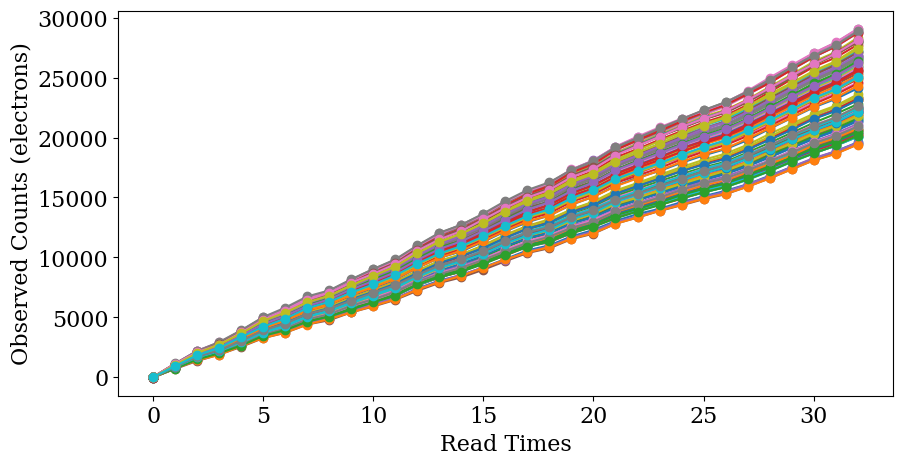

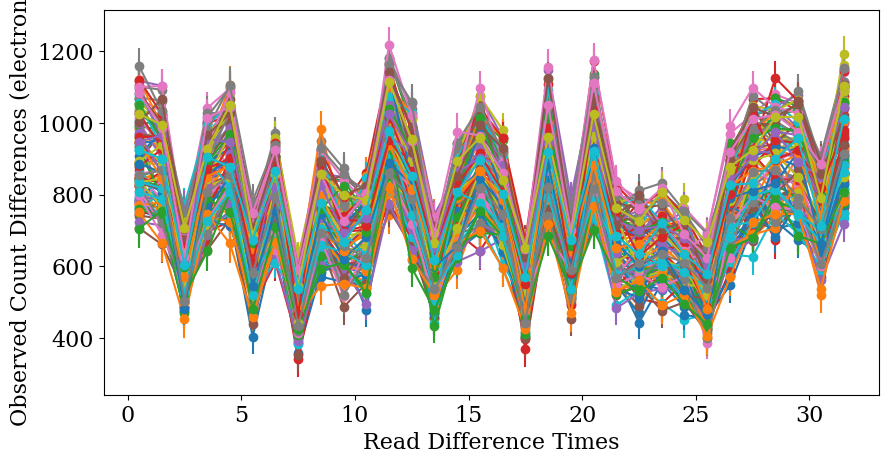

In [4]:

plt.figure(figsize=(10,5))
for j in range(n_pixels):
    plt.errorbar(read_times,obs_fluxes[j],yerr=obs_fluxes_errs[j],fmt='-o')
plt.xlabel('Read Times')
plt.ylabel('Observed Counts (electrons)')
plt.show()

plt.figure(figsize=(10,5))
for j in range(n_pixels):
    plt.errorbar(read_diff_times,obs_flux_diffs[j],yerr=obs_flux_diff_errs[j],fmt='-o')
plt.xlabel('Read Difference Times')
plt.ylabel('Observed Count Differences (electrons)')
plt.show()


In [5]:
max_b_ind,b_vect_mean,b_vect_Vinv,b_vect_V,\
        f_max_means_given_b,f_max_ivars_given_b,\
        comb_param_means,comb_param_Vinv,comb_param_V,comb_param_samps = fit_flux.measure_time_dep_fluxes_GIBBS(obs_fluxes,read_errs,
                                                       n_samples=10000,b_vect_change_tol=1e-10,f_max_change_tol=1e-10,
                                                       min_b_val=1e-10,min_f_val=1e-10,
                                                       rescale=True,true_b_vect=true_b_vect,
                                                       true_fluxes=true_fluxes,
                                                       use_linear_first_guess=True,
                                                       verbose=True,return_samples=True)

f_means_no_b,f_ivars_no_b,chi2s_data_no_b = fit_flux.fit_fluxes_optimal(obs_fluxes,read_errs,
                                                                           n_repeat=2,b_vect=None)
f_means_with_b,f_ivars_with_b,chi2s_data_with_b = fit_flux.fit_fluxes_optimal(obs_fluxes,read_errs,
                                                                           n_repeat=2,b_vect=b_vect_mean)

non_max_inds = np.ones(len(b_vect_mean)).astype(bool)
non_max_inds[max_b_ind] = False
non_max_inds = np.where(non_max_inds)[0]

b_vect_errs = np.sqrt(np.diag(b_vect_V))
f_max_errs_given_b = np.power(f_max_ivars_given_b,-0.5)

b_vect_mean_gibbs = np.copy(b_vect_mean)
b_vect_errs_gibbs = np.copy(b_vect_errs)
b_vect_cov_gibbs = np.copy(b_vect_V)
comb_param_samps_gibbs = np.copy(comb_param_samps)

Done updating f max and b vect using linearized approach. Took 5 iterations to converge.
b vect change summary: [0.00000000e+00 1.77191595e-15 7.16093851e-15 1.50013335e-14
 4.39648318e-14]
f max change summary:  [0.00000000e+00 2.97859515e-12 1.32445166e-11 2.73394107e-11
 7.45785655e-11]
Using Gibbs sampling to generate 10000 samples


100%|████████████████████████████████████| 10000/10000 [00:56<00:00, 176.45it/s]

Done


In [6]:
max_b_ind,b_vect_mean,b_vect_Vinv,b_vect_V,\
        f_max_means_given_b,f_max_ivars_given_b,\
        comb_param_means,comb_param_Vinv,comb_param_V = fit_flux.measure_time_dep_fluxes_LINEAR(obs_fluxes,read_errs,
                                                       n_max_repeat=1000,b_vect_change_tol=1e-10,
                                                       f_max_change_tol=1e-10,
                                                       min_b_val=1e-10,min_f_val=1e-10,
                                                       rescale=True,true_b_vect=true_b_vect,
                                                       true_fluxes=true_fluxes,verbose=True)

f_means_no_b,f_ivars_no_b,chi2s_data_no_b = fit_flux.fit_fluxes_optimal(obs_fluxes,read_errs,
                                                                           n_repeat=2,b_vect=None)
f_means_with_b,f_ivars_with_b,chi2s_data_with_b = fit_flux.fit_fluxes_optimal(obs_fluxes,read_errs,
                                                                           n_repeat=2,b_vect=b_vect_mean)
f_means_equal_weight,f_ivars_equal_weights = fit_flux.fit_fluxes_rauscher(obs_fluxes,read_errs)


non_max_inds = np.ones(len(b_vect_mean)).astype(bool)
non_max_inds[max_b_ind] = False
non_max_inds = np.where(non_max_inds)[0]

b_vect_errs = np.sqrt(np.diag(b_vect_V))
f_max_errs_given_b = np.power(f_max_ivars_given_b,-0.5)

b_vect_mean_linear = np.copy(b_vect_mean)
b_vect_errs_linear = np.copy(b_vect_errs)
b_vect_cov_linear = np.copy(b_vect_V)

#draw samples from the linearized-method
n_samples = 10000
curr_L = np.linalg.cholesky(comb_param_V)
comb_param_samps = np.einsum('ij,nj->ni',curr_L,np.random.randn(n_samples,len(comb_param_means)))+comb_param_means
comb_param_samps_linear = np.copy(comb_param_samps)

Done updating f max and b vect using linearized approach. Took 5 iterations to converge.
b vect change summary: [0.00000000e+00 1.77191595e-15 7.16093851e-15 1.50013335e-14
 4.39648318e-14]
f max change summary:  [0.00000000e+00 2.97859515e-12 1.32445166e-11 2.73394107e-11
 7.45785655e-11]


In [7]:
#range of fluxes to extract using measured b vect
n_test_range_pixels = 21
test_range_fluxes = np.logspace(1,3,n_test_range_pixels)

#number of times to repeat fitting the above flux (different draws)
n_repeat_test_range = 1000

min_b_val = 1e-10

test_f_given_b_zscores_with_bs = np.zeros((n_repeat_test_range,n_test_range_pixels))
test_f_given_b_chi2s_with_bs = np.zeros((n_repeat_test_range,n_test_range_pixels))
test_f_given_b_errs_with_bs = np.zeros((n_repeat_test_range,n_test_range_pixels))
test_f_given_b_zscores_no_bs = np.zeros((n_repeat_test_range,n_test_range_pixels))
test_f_given_b_chi2s_no_bs = np.zeros((n_repeat_test_range,n_test_range_pixels))
test_f_given_b_errs_no_bs = np.zeros((n_repeat_test_range,n_test_range_pixels))

test_f_given_b_zscores_equal_weights = np.zeros((n_repeat_test_range,n_test_range_pixels))
test_f_given_b_chi2s_equal_weights = np.zeros((n_repeat_test_range,n_test_range_pixels))
test_f_given_b_errs_equal_weights = np.zeros((n_repeat_test_range,n_test_range_pixels))

true_high_fluxes = np.ones(n_pixels)*test_range_fluxes.max()
for test_ind in range(n_repeat_test_range):
    curr_read_errs = ((np.random.rand(n_test_range_pixels)-0.5)*2)*5 + 19
    curr_high_obs_fluxes = fit_flux.generate_data(read_errs,
                                                  true_high_fluxes,
                                                  true_b_vect)
    curr_test_obs_fluxes = fit_flux.generate_data(curr_read_errs,test_range_fluxes,true_b_vect)

    #use high flux pixels to measure scaling with flux for fair comparison
    curr_f_means_no_b,curr_f_ivars_no_b,curr_chi2s_data_no_b = fit_flux.fit_fluxes_optimal(curr_high_obs_fluxes,
                                                  read_errs,n_repeat=2,b_vect=None)  
    curr_mult_var = 1/np.sum(np.power(curr_f_means_no_b,2)*curr_f_ivars_no_b)
    curr_mult_mean = curr_mult_var * np.sum(curr_f_means_no_b*true_high_fluxes*curr_f_ivars_no_b)
    # curr_mult_mean = curr_mult_mean + np.random.randn()*np.sqrt(curr_mult_var)

    curr_f_means_no_b,curr_f_ivars_no_b,curr_chi2s_data_no_b = fit_flux.fit_fluxes_optimal(curr_test_obs_fluxes,
                                                  curr_read_errs,n_repeat=2,b_vect=None)  
    
    # curr_mult_mean = mult_mean + np.random.randn()*np.sqrt(mult_var)
    # curr_mult_mean = mult_mean

    # curr_mult_var = 1/np.sum(np.power(curr_f_means_no_b,2)*curr_f_ivars_no_b)
    # curr_mult_mean = curr_mult_var * np.sum(curr_f_means_no_b*test_range_fluxes*curr_f_ivars_no_b)
    # curr_mult_mean = curr_mult_mean + np.random.randn()*np.sqrt(curr_mult_var)

    curr_f_means_no_b *= curr_mult_mean
    curr_f_ivars_no_b /= curr_mult_mean**2

    curr_f_means_with_b,curr_f_ivars_with_b,curr_chi2s_data_with_b = fit_flux.fit_fluxes_optimal(curr_high_obs_fluxes,
                                                                    read_errs,n_repeat=2,
                                                                    b_vect=np.maximum(b_vect_mean,min_b_val))
    curr_mult_var = 1/np.sum(np.power(curr_f_means_with_b,2)*curr_f_ivars_with_b)
    curr_mult_mean = curr_mult_var * np.sum(curr_f_means_with_b*true_high_fluxes*curr_f_ivars_with_b)
    # curr_mult_mean = curr_mult_mean + np.random.randn()*np.sqrt(curr_mult_var)

    curr_f_means_with_b,curr_f_ivars_with_b,curr_chi2s_data_with_b = fit_flux.fit_fluxes_optimal(curr_test_obs_fluxes,
                                                                    curr_read_errs,n_repeat=2,
                                                                    b_vect=np.maximum(b_vect_mean,min_b_val))

    # curr_mult_var = 1/np.sum(np.power(curr_f_means_with_b,2)*curr_f_ivars_with_b)
    # curr_mult_mean = curr_mult_var * np.sum(curr_f_means_with_b*test_range_fluxes*curr_f_ivars_with_b)
    # curr_mult_mean = curr_mult_mean + np.random.randn()*np.sqrt(curr_mult_var)

    curr_f_means_with_b *= curr_mult_mean
    curr_f_ivars_with_b /= curr_mult_mean**2

    curr_f_means_equal_weights,curr_f_ivars_equal_weights = fit_flux.fit_fluxes_rauscher(curr_high_obs_fluxes,read_errs)
    curr_mult_var = 1/np.sum(np.power(curr_f_means_equal_weights,2)*curr_f_ivars_equal_weights)
    curr_mult_mean = curr_mult_var * np.sum(curr_f_means_equal_weights*true_high_fluxes*curr_f_ivars_equal_weights)
    # curr_mult_mean = curr_mult_mean + np.random.randn()*np.sqrt(curr_mult_var)

    curr_f_means_equal_weights,curr_f_ivars_equal_weights = fit_flux.fit_fluxes_rauscher(curr_test_obs_fluxes,curr_read_errs)

    # curr_mult_var = 1/np.sum(np.power(curr_f_means_with_b,2)*curr_f_ivars_with_b)
    # curr_mult_mean = curr_mult_var * np.sum(curr_f_means_with_b*test_range_fluxes*curr_f_ivars_with_b)
    # curr_mult_mean = curr_mult_mean + np.random.randn()*np.sqrt(curr_mult_var)

    curr_f_means_equal_weights *= curr_mult_mean
    curr_f_ivars_equal_weights /= curr_mult_mean**2
    
    
    test_f_given_b_zscores_with_bs[test_ind] = (curr_f_means_with_b-test_range_fluxes)*np.sqrt(curr_f_ivars_with_b)
    test_f_given_b_chi2s_with_bs[test_ind] = np.sum(np.power(test_f_given_b_zscores_with_bs[test_ind],2))
    test_f_given_b_errs_with_bs[test_ind] = np.power(curr_f_ivars_with_b,-0.5)

    test_f_given_b_zscores_no_bs[test_ind] = (curr_f_means_no_b-test_range_fluxes)*np.sqrt(curr_f_ivars_no_b)
    test_f_given_b_chi2s_no_bs[test_ind] = np.sum(np.power(test_f_given_b_zscores_no_bs[test_ind],2))
    test_f_given_b_errs_no_bs[test_ind] = np.power(curr_f_ivars_no_b,-0.5)
    
    test_f_given_b_zscores_equal_weights[test_ind] = (curr_f_means_equal_weights-test_range_fluxes)*np.sqrt(curr_f_ivars_equal_weights)
    test_f_given_b_chi2s_equal_weights[test_ind] = np.sum(np.power(test_f_given_b_zscores_equal_weights[test_ind],2))
    test_f_given_b_errs_equal_weights[test_ind] = np.power(curr_f_ivars_equal_weights,-0.5)


In [8]:
percentiles = [stats.norm.sf(1)*100,50,stats.norm.sf(-1)*100]

n_norm = 1000
norm_mean_summaries = np.zeros((n_norm,3))
width_mean_summaries = np.zeros((n_norm,3))

for j in range(n_norm):
    norm_data = np.random.randn(n_repeat_test_range)
    summaries_norm = np.nanpercentile(norm_data,percentiles)
    norm_mean_summaries[j] = np.nanpercentile(summaries_norm[1],percentiles)
    width_mean_summaries[j] = np.nanpercentile(0.5*(summaries_norm[2]-summaries_norm[0]),percentiles)


norm_mean_est = np.nanmedian(norm_mean_summaries[:,1],axis=0)
norm_mean_std_est = 0.5*(np.nanpercentile(norm_mean_summaries[:,1],percentiles[2],axis=0)\
                         -np.nanpercentile(norm_mean_summaries[:,1],percentiles[0],axis=0))
norm_width_est = np.nanmedian(width_mean_summaries[:,1],axis=0)
norm_width_std_est = 0.5*(np.nanpercentile(width_mean_summaries[:,1],percentiles[2],axis=0)\
                         -np.nanpercentile(width_mean_summaries[:,1],percentiles[0],axis=0))


/var/folders/xs/flwfyss51t7d8vd8jhqz00xh0000gn/T/ipykernel_74370/336889761.py:129: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


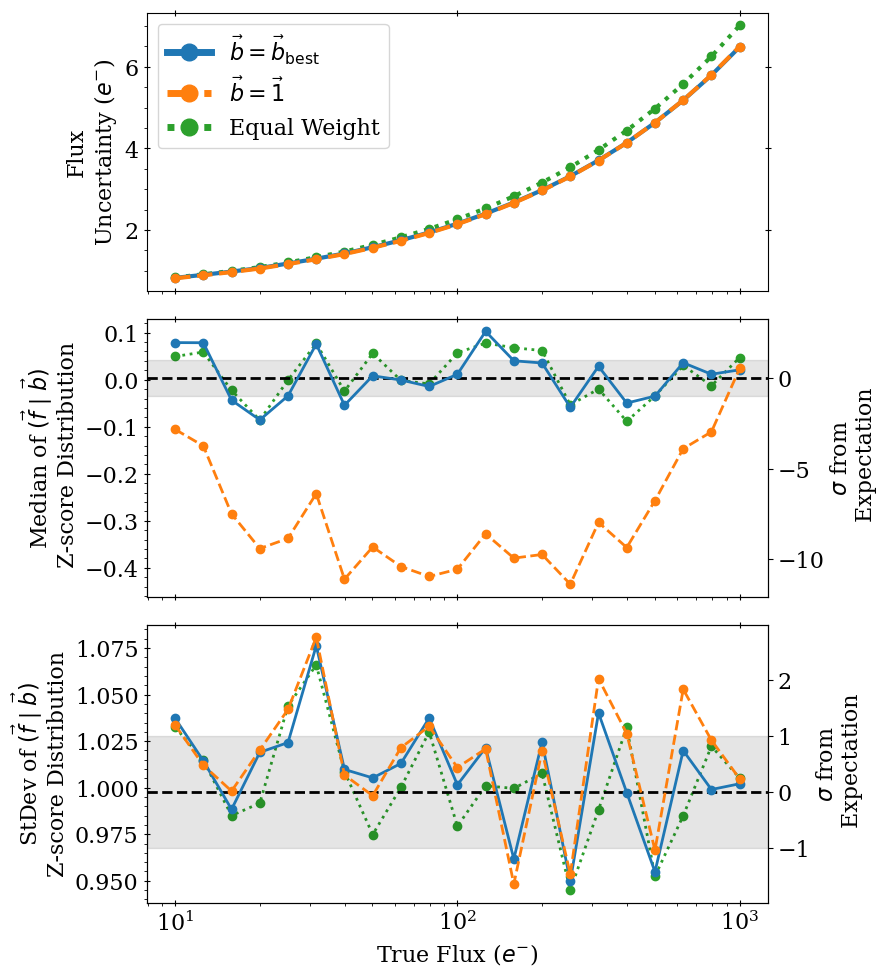

In [9]:


summaries_with_b = np.nanpercentile(test_f_given_b_zscores_with_bs,percentiles,axis=0)
means_with_b = summaries_with_b[1]
widths_with_b = 0.5*(summaries_with_b[2]-summaries_with_b[0])
summaries_no_b = np.nanpercentile(test_f_given_b_zscores_no_bs,percentiles,axis=0)
means_no_b = summaries_no_b[1]
widths_no_b = 0.5*(summaries_no_b[2]-summaries_no_b[0])
summaries_equal_weights = np.nanpercentile(test_f_given_b_zscores_equal_weights,percentiles,axis=0)
means_equal_weights = summaries_equal_weights[1]
widths_equal_weights = 0.5*(summaries_equal_weights[2]-summaries_equal_weights[0])

err_summaries_with_b = np.nanpercentile(test_f_given_b_errs_with_bs,percentiles,axis=0)
err_summaries_no_b = np.nanpercentile(test_f_given_b_errs_no_bs,percentiles,axis=0)
err_summaries_equal_weights = np.nanpercentile(test_f_given_b_errs_equal_weights,percentiles,axis=0)

plt.figure(figsize=(9,10))
gs = gridspec.GridSpec(3,1,hspace=0.1, left=0.16, right=0.85, top=0.98, bottom = 0.09)
ax = plt.subplot(gs[0,0])    
ax.set_xscale('log')
plt.minorticks_on()
ax.tick_params(axis='both',direction='inout',length=5,bottom=True,left=True,right=True,top=True)

# plt.figure(figsize=(8,4))
# ax = plt.gca()
ax.set_xscale('log')
# ax.set_yscale('log')
plt.plot(test_range_fluxes,
         err_summaries_with_b[1],
         color='C0',lw=3,marker='o',
         label=r'$\vec b = \vec b_{\mathrm{best}}$')
# plt.fill_between(test_range_fluxes,
#          err_summaries_with_b[0],
#          err_summaries_with_b[2],
#          color='C0',alpha=0.35)
plt.plot(test_range_fluxes,
         err_summaries_no_b[1],
         color='C1',lw=3,ls='--',marker='o',
      label=r'$\vec b = \vec 1$')
plt.plot(test_range_fluxes,
         err_summaries_equal_weights[1],
         color='C2',lw=3,ls=':',zorder=-1e10,marker='o',
      label=r'Equal Weight')
# plt.fill_between(test_range_fluxes,
#          err_summaries_no_b[0],
#          err_summaries_no_b[2],
#          color='C1',alpha=0.35)
plt.ylabel('Flux\n'+r'Uncertainty ($e^{-}$)')

leg = plt.legend(loc='best',markerscale=2)
for line in leg.get_lines():
    line.set_linewidth(5)
ax.set_xticklabels([])

# plt.xlabel(r'True Flux ($e^{-1}$)')
# plt.tight_layout()
# plt.show()


ax = plt.subplot(gs[1,0])    
ax.set_xscale('log')
plt.minorticks_on()
ax.tick_params(axis='both',direction='inout',length=5,bottom=True,left=True,right=True,top=True)

# plt.figure(figsize=(8,4))
# ax = plt.gca()

ax.set_xscale('log')
plt.axhline(norm_mean_est,c='k',lw=2,ls='--')
plt.axhspan(norm_mean_est-norm_mean_std_est,norm_mean_est+norm_mean_std_est,color='k',alpha=0.1)
plt.plot(test_range_fluxes,
         means_with_b,
         color='C0',lw=2,marker='o',
         label=r'$\vec b = \vec b_{\mathrm{best}}$')
plt.plot(test_range_fluxes,
         means_no_b,
         color='C1',lw=2,ls='--',marker='o',
      label=r'$\vec b = \vec 1$')
plt.plot(test_range_fluxes,
         means_equal_weights,
         color='C2',lw=2,zorder=-1e10,ls=':',marker='o',
      label=r'Equal Weights')
# leg = plt.legend(loc='best')
# for line in leg.get_lines():
#     line.set_linewidth(5)
# plt.xlabel('True Flux (electrons)')
# plt.ylabel('Median of\n'+r' $(\vec f \mid \vec b)$ Z-score'+'\n Distribution')
plt.ylabel('Median of'+r' $(\vec f \mid \vec b)$'+'\n Z-score Distribution')
ax.set_xticklabels([])
ylim = np.array(plt.ylim())
ax1 = ax.twinx()
ax1.set_ylim((ylim-norm_mean_est)/norm_mean_std_est)
plt.ylabel(r'$\sigma$ from'+'\n Expectation')
# plt.tight_layout()
# plt.show()


ax = plt.subplot(gs[2,0])    
ax.set_xscale('log')
plt.minorticks_on()
ax.tick_params(axis='both',direction='inout',length=5,bottom=True,left=True,right=True,top=True)

# plt.figure(figsize=(8,4))
# ax = plt.gca()

ax.set_xscale('log')
plt.axhline(norm_width_est,c='k',lw=2,ls='--')
plt.axhspan(norm_width_est-norm_width_std_est,norm_width_est+norm_width_std_est,color='k',alpha=0.1)
plt.plot(test_range_fluxes,
         widths_with_b,
         color='C0',lw=2,marker='o',
         label=r'$\vec b = \vec b_{\mathrm{best}}$')
plt.plot(test_range_fluxes,
         widths_no_b,
         color='C1',lw=2,ls='--',marker='o',
      label=r'$\vec b = \vec 1$')
plt.plot(test_range_fluxes,
         widths_equal_weights,
         color='C2',lw=2,zorder=-1e10,ls=':',marker='o',
      label=r'Equal Weights')
# leg = plt.legend(loc='best')
# for line in leg.get_lines():
#     line.set_linewidth(5)
plt.xlabel(r'True Flux ($e^{-}$)')
plt.ylabel(r'StDev of $(\vec f \mid \vec b)$'+'\nZ-score Distribution')
# plt.ylabel(r'$\frac{1}{2}\cdot$'+'68% Width of\n '+r'$(\vec f \mid \vec b)$ Z-score'+'\n Distribution')
ylim = np.array(plt.ylim())
ax1 = ax.twinx()
ax1.set_ylim((ylim-norm_width_est)/norm_width_std_est)
plt.ylabel(r'$\sigma$ from'+'\n Expectation')
plt.tight_layout()
plt.savefig(f'{plotpath}single_fit_model_bias.png')
plt.show()


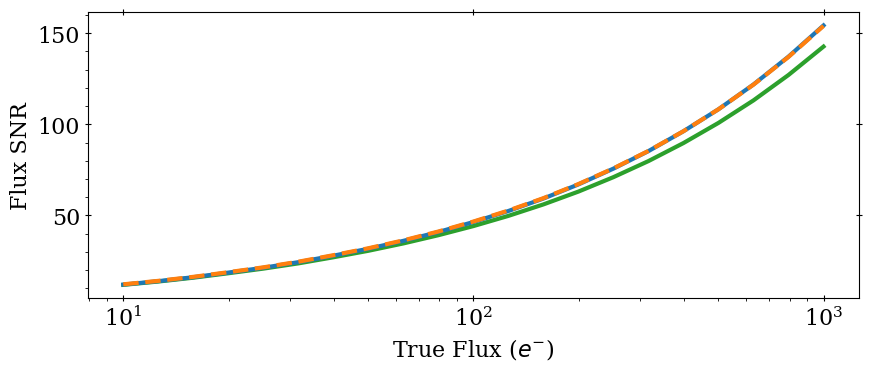

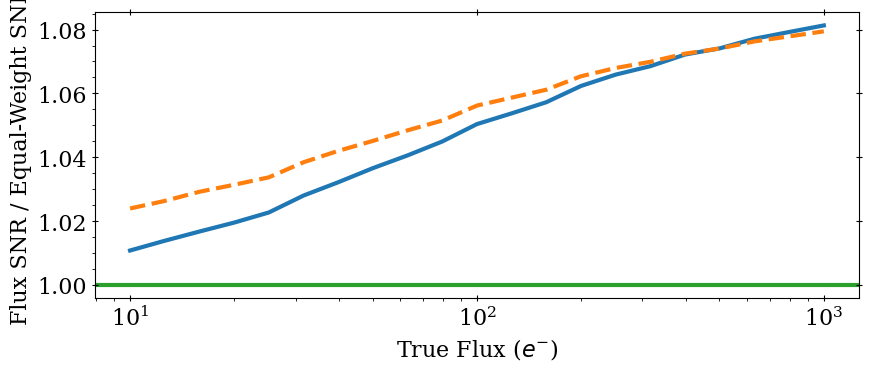

In [10]:
plt.figure(figsize=(9,4))
ax = plt.gca()
ax.set_xscale('log')
plt.minorticks_on()
ax.tick_params(axis='both',direction='inout',length=5,bottom=True,left=True,right=True,top=True)

# plt.figure(figsize=(8,4))
# ax = plt.gca()
ax.set_xscale('log')
# ax.set_yscale('log')
plt.plot(test_range_fluxes,
         test_range_fluxes/err_summaries_with_b[1],
         color='C0',lw=3,
         label=r'$\vec b = \vec b_{\mathrm{best}}$')
# plt.fill_between(test_range_fluxes,
#          err_summaries_with_b[0],
#          err_summaries_with_b[2],
#          color='C0',alpha=0.35)
plt.plot(test_range_fluxes,
         test_range_fluxes/err_summaries_no_b[1],
         color='C1',lw=3,ls='--',
      label=r'$\vec b = \vec 1$')
plt.plot(test_range_fluxes,
         test_range_fluxes/err_summaries_equal_weights[1],
         color='C2',lw=3,ls='-',zorder=-1e10,
      label=r'Equal Weight')
plt.xlabel(r'True Flux ($e^{-}$)')
plt.ylabel(r'Flux SNR')

plt.tight_layout()
plt.show()

div_vals = test_range_fluxes/err_summaries_equal_weights[1]

plt.figure(figsize=(9,4))
ax = plt.gca()
ax.set_xscale('log')
plt.minorticks_on()
ax.tick_params(axis='both',direction='inout',length=5,bottom=True,left=True,right=True,top=True)

# plt.figure(figsize=(8,4))
# ax = plt.gca()
ax.set_xscale('log')
# ax.set_yscale('log')
plt.plot(test_range_fluxes,
         test_range_fluxes/err_summaries_with_b[1]/div_vals,
         color='C0',lw=3,
         label=r'$\vec b = \vec b_{\mathrm{best}}$')
# plt.fill_between(test_range_fluxes,
#          err_summaries_with_b[0],
#          err_summaries_with_b[2],
#          color='C0',alpha=0.35)
plt.plot(test_range_fluxes,
         test_range_fluxes/err_summaries_no_b[1]/div_vals,
         color='C1',lw=3,ls='--',
      label=r'$\vec b = \vec 1$')
plt.axhline(1.0,color='C2',lw=3,ls='-',zorder=-1e10,
      label=r'Equal Weight')
plt.xlabel(r'True Flux ($e^{-}$)')
plt.ylabel(r'Flux SNR / Equal-Weight SNR')

plt.tight_layout()
plt.show()


In [11]:
true_param_means = np.zeros_like(comb_param_means)
true_param_means[:n_pixels] = true_fluxes
true_param_means[n_pixels:] = true_b_vect[non_max_inds]

diff = (comb_param_means-true_param_means)
full_chi2 = np.dot(np.dot(diff,comb_param_Vinv),diff)
indv_chi2 = np.sum((np.power(diff,2)/(np.diag(comb_param_V))))

print(full_chi2/len(diff),indv_chi2/len(diff),len(diff))

0.8480301439295629 0.5765354496239895 131


In [12]:
diff = (comb_param_means-true_param_means)[:n_pixels]
full_chi2 = np.dot(np.dot(diff,comb_param_Vinv[:n_pixels,:n_pixels]),diff)
indv_chi2 = np.sum((np.power(diff,2)/(np.diag(comb_param_V)[:n_pixels])))

print(full_chi2/len(diff),indv_chi2/len(diff),len(diff))

diff = (f_max_means_given_b-true_fluxes)
indv_chi2 = np.sum((np.power(diff/f_max_errs_given_b,2)))

print(indv_chi2/len(diff),len(diff))


0.7503821938174395 0.5320741438177921 100
0.7503821938174389 100


In [13]:
diff = (comb_param_means-true_param_means)[n_pixels:]
full_chi2 = np.dot(np.dot(diff,comb_param_Vinv[n_pixels:,n_pixels:]),diff)
indv_chi2 = np.sum((np.power(diff,2)/(np.diag(comb_param_V)[n_pixels:])))

print(full_chi2/len(diff),indv_chi2/len(diff),len(diff))

diff = (b_vect_mean-true_b_vect)[non_max_inds]
full_chi2 = np.dot(np.dot(diff,b_vect_Vinv[non_max_inds][:,non_max_inds]),diff)
indv_chi2 = np.sum((np.power(diff,2)/(np.diag(b_vect_V)[non_max_inds])))

print(full_chi2/len(diff),indv_chi2/len(diff),len(diff))


1.1600557460295489 0.7199590167407551 31
1.1600557460295489 0.7199590167407551 31


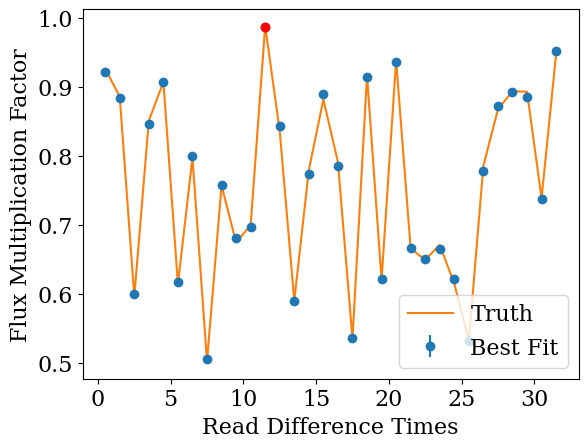

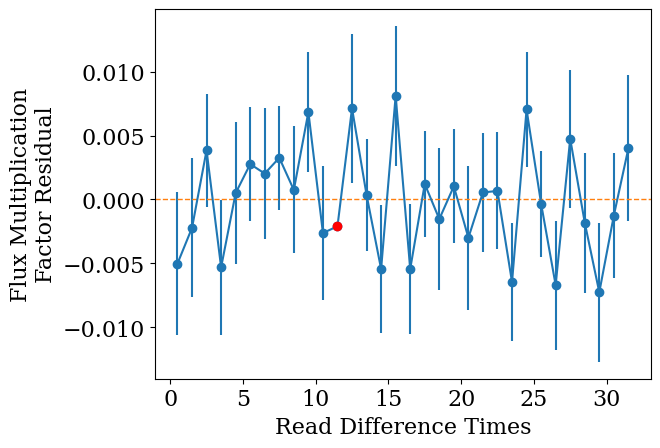

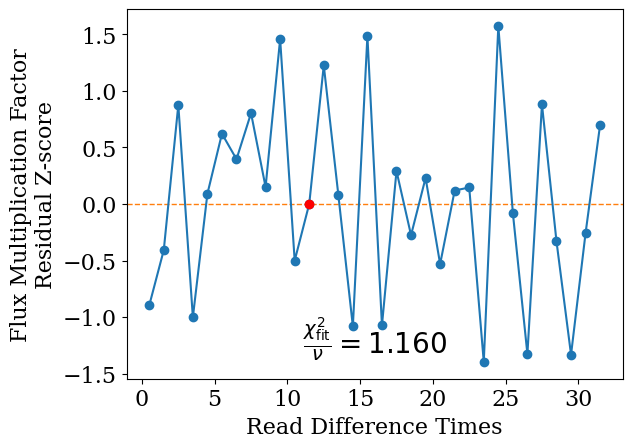

In [14]:
diff = (b_vect_mean-true_b_vect)[non_max_inds]
full_chi2 = np.dot(np.dot(diff,b_vect_Vinv[non_max_inds][:,non_max_inds]),diff)

b_vect_fit_scaled_chi2 = full_chi2/len(diff)
chi2_label = r'$\frac{\chi_{\mathrm{fit}}^2}{\nu} = %.3f$'%b_vect_fit_scaled_chi2

plt.errorbar(read_diff_times,b_vect_mean,yerr=b_vect_errs,fmt='o',label='Best Fit')
plt.errorbar(read_diff_times[max_b_ind],b_vect_mean[max_b_ind],
             yerr=b_vect_errs[max_b_ind],
             fmt='o',color='r')
plt.plot(read_diff_times,true_b_vect,label='Truth')
plt.xlabel('Read Difference Times')
plt.ylabel('Flux Multiplication Factor')
leg = plt.legend(loc='best')
plt.show()

plt.errorbar(read_diff_times,b_vect_mean-true_b_vect,yerr=b_vect_errs,fmt='-o')
plt.errorbar(read_diff_times[max_b_ind],(b_vect_mean-true_b_vect)[max_b_ind],
             yerr=b_vect_errs[max_b_ind],
             fmt='-o',color='r')
plt.axhline(0,c='C1',ls='--',lw=1)
plt.xlabel('Read Difference Times')
plt.ylabel('Flux Multiplication\nFactor Residual')
plt.show()

z_scores = (b_vect_mean-true_b_vect)/b_vect_errs
plt.errorbar(read_diff_times,z_scores,fmt='-o')
plt.errorbar(read_diff_times[max_b_ind],z_scores[max_b_ind],
             fmt='-o',color='r')
plt.text(np.mean(read_diff_times),np.min(z_scores),
         chi2_label,va='bottom',ha='center',fontsize=20)
plt.axhline(0,c='C1',ls='--',lw=1)
plt.xlabel('Read Difference Times')
plt.ylabel('Flux Multiplication Factor\nResidual Z-score')
plt.show()


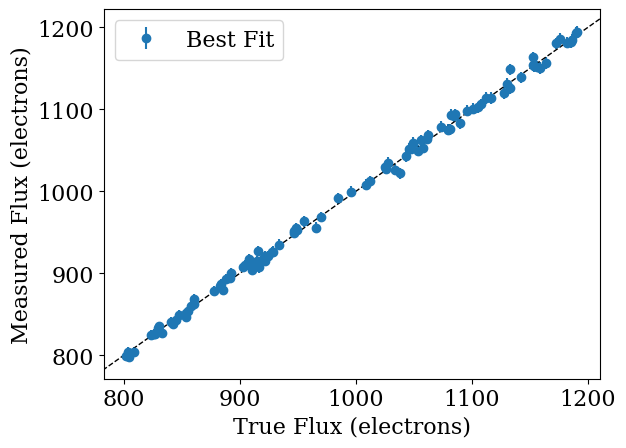

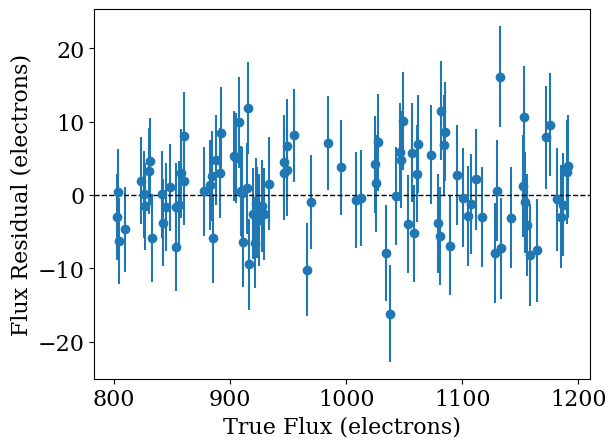

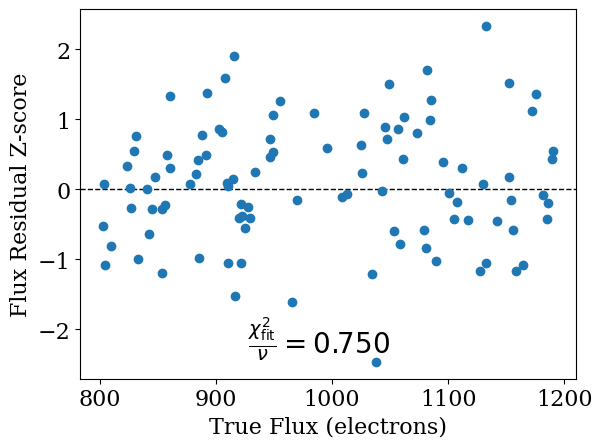

In [15]:
diff = (f_means_with_b-true_fluxes)
indv_chi2 = np.sum((np.power(diff/np.sqrt(1/f_ivars_with_b),2)))

fluxes_fit_scaled_chi2 = indv_chi2/len(diff)
chi2_label = r'$\frac{\chi_{\mathrm{fit}}^2}{\nu} = %.3f$'%fluxes_fit_scaled_chi2


pixel_inds = np.arange(n_pixels)

# plt.errorbar(true_fluxes,f_max_means_given_b,yerr=np.sqrt(1/f_max_ivars_given_b),fmt='o',label='Best Fit')
plt.errorbar(true_fluxes,f_means_with_b,yerr=np.sqrt(1/f_ivars_with_b),fmt='o',label=r'Best Fit')
# plt.errorbar(true_fluxes,f_means_with_b,yerr=np.sqrt(1/f_ivars_with_b),fmt='o',label=r'Best Fit, with $\vec b$')
# plt.errorbar(true_fluxes,f_means_no_b,yerr=np.sqrt(1/f_ivars_no_b),fmt='o',label=r'Best Fit, no $\vec b$')
plt.xlabel('True Flux (electrons)')
plt.ylabel('Measured Flux (electrons)')
leg = plt.legend(loc='best')
xlim = plt.xlim()
ylim = plt.ylim()
line_xy = [min(xlim[0],ylim[0]),max(xlim[1],ylim[1])]
plt.plot(line_xy,line_xy,c='k',ls='--',lw=1)
plt.xlim(xlim)
plt.ylim(ylim)
plt.show()

# plt.errorbar(true_fluxes,f_max_means_given_b-true_fluxes,yerr=np.sqrt(1/f_max_ivars_given_b),fmt='o')
plt.errorbar(true_fluxes,f_means_with_b-true_fluxes,yerr=np.sqrt(1/f_ivars_with_b),fmt='o')
plt.axhline(0,c='k',ls='--',lw=1)
plt.xlabel('True Flux (electrons)')
plt.ylabel('Flux Residual (electrons)')
plt.show()

zscores = (f_means_with_b-true_fluxes)*np.sqrt(f_ivars_with_b)
# plt.errorbar(true_fluxes,(f_max_means_given_b-true_fluxes)*np.sqrt(f_max_ivars_given_b),fmt='o')
plt.errorbar(true_fluxes,zscores,fmt='o')
plt.text(np.mean(true_fluxes),np.min(zscores),
         chi2_label,va='bottom',ha='center',fontsize=20)
plt.axhline(0,c='k',ls='--',lw=1)
plt.xlabel('True Flux (electrons)')
plt.ylabel('Flux Residual Z-score')
plt.show()


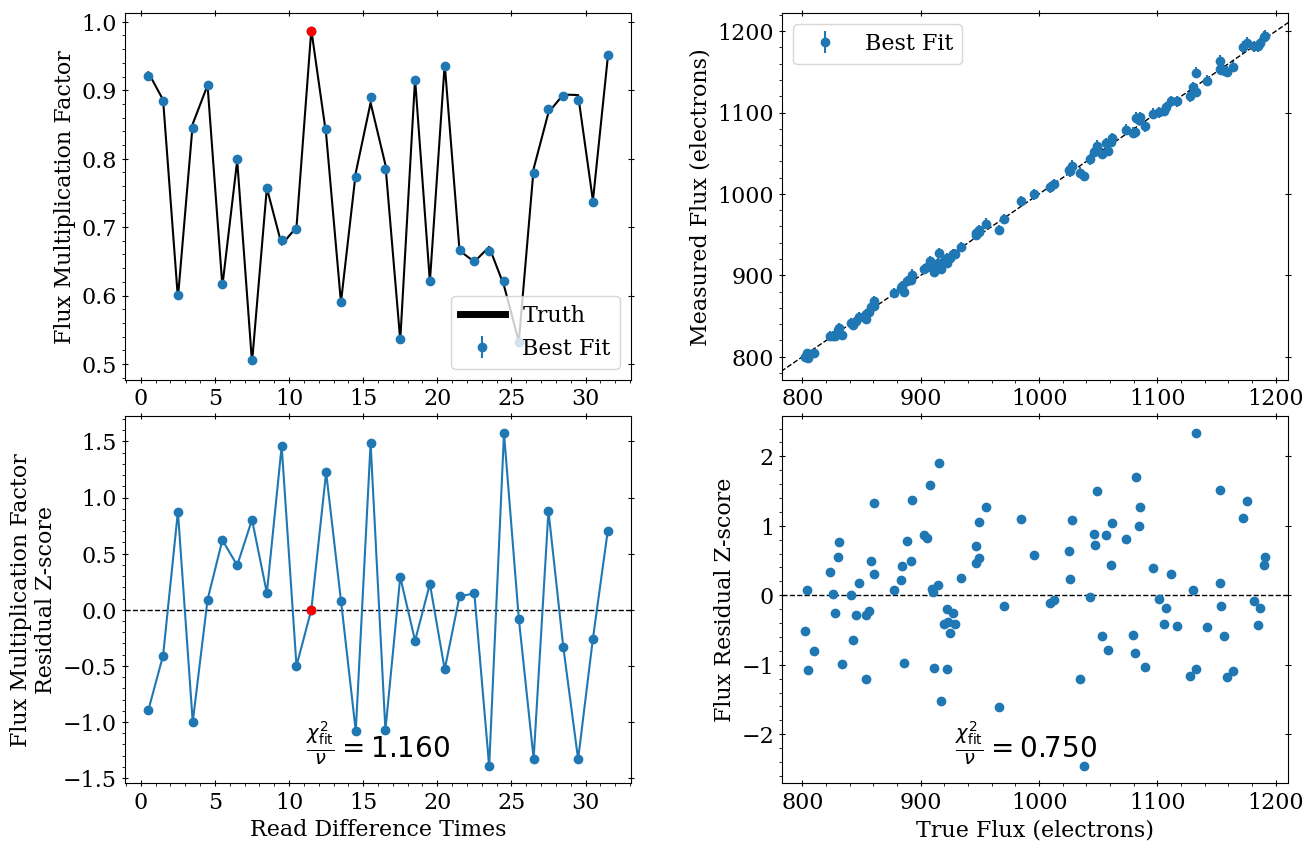

In [16]:
plt.figure(figsize=(15,10))
gs = gridspec.GridSpec(2,2,wspace=0.3,hspace=0.1)
ax = plt.subplot(gs[0,0])    
plt.minorticks_on()
ax.tick_params(axis='both',direction='inout',length=5,bottom=True,left=True,right=True,top=True)

diff = (b_vect_mean-true_b_vect)[non_max_inds]
full_chi2 = np.dot(np.dot(diff,b_vect_Vinv[non_max_inds][:,non_max_inds]),diff)

b_vect_fit_scaled_chi2 = full_chi2/len(diff)
chi2_label = r'$\frac{\chi_{\mathrm{fit}}^2}{\nu} = %.3f$'%b_vect_fit_scaled_chi2

plt.errorbar(read_diff_times,b_vect_mean,yerr=b_vect_errs,fmt='o',label='Best Fit')
plt.errorbar(read_diff_times[max_b_ind],b_vect_mean[max_b_ind],
             yerr=b_vect_errs[max_b_ind],
             fmt='o',color='r')
plt.plot(read_diff_times,true_b_vect,label='Truth',c='k')
# plt.xlabel('Read Difference Times')
plt.ylabel('Flux Multiplication Factor')
leg = plt.legend(loc='best')
for line in leg.get_lines():
    line.set_linewidth(5)



ax = plt.subplot(gs[1,0])    
plt.minorticks_on()
ax.tick_params(axis='both',direction='inout',length=5,bottom=True,left=True,right=True,top=True)

z_scores = (b_vect_mean-true_b_vect)/b_vect_errs
plt.errorbar(read_diff_times,z_scores,fmt='-o')
plt.errorbar(read_diff_times[max_b_ind],z_scores[max_b_ind],
             fmt='-o',color='r')
plt.text(np.mean(read_diff_times),np.min(z_scores),
         chi2_label,va='bottom',ha='center',fontsize=20)
plt.axhline(0,c='k',ls='--',lw=1)
plt.xlabel('Read Difference Times')
plt.ylabel('Flux Multiplication Factor\nResidual Z-score')

ax = plt.subplot(gs[0,1])    
plt.minorticks_on()
ax.tick_params(axis='both',direction='inout',length=5,bottom=True,left=True,right=True,top=True)

diff = (f_means_with_b-true_fluxes)
indv_chi2 = np.sum((np.power(diff/np.sqrt(1/f_ivars_with_b),2)))

fluxes_fit_scaled_chi2 = indv_chi2/len(diff)
chi2_label = r'$\frac{\chi_{\mathrm{fit}}^2}{\nu} = %.3f$'%fluxes_fit_scaled_chi2

pixel_inds = np.arange(n_pixels)

# plt.errorbar(true_fluxes,f_max_means_given_b,yerr=np.sqrt(1/f_max_ivars_given_b),fmt='o',label='Best Fit')
plt.errorbar(true_fluxes,f_means_with_b,yerr=np.sqrt(1/f_ivars_with_b),fmt='o',label=r'Best Fit')
# plt.errorbar(true_fluxes,f_means_with_b,yerr=np.sqrt(1/f_ivars_with_b),fmt='o',label=r'Best Fit, with $\vec b$')
# plt.errorbar(true_fluxes,f_means_no_b,yerr=np.sqrt(1/f_ivars_no_b),fmt='o',label=r'Best Fit, no $\vec b$')
# plt.xlabel('True Flux (electrons)')
plt.ylabel('Measured Flux (electrons)')
leg = plt.legend(loc='best')
xlim = plt.xlim()
ylim = plt.ylim()
line_xy = [min(xlim[0],ylim[0]),max(xlim[1],ylim[1])]
plt.plot(line_xy,line_xy,c='k',ls='--',lw=1)
plt.xlim(xlim)
plt.ylim(ylim)

ax = plt.subplot(gs[1,1])    
plt.minorticks_on()
ax.tick_params(axis='both',direction='inout',length=5,bottom=True,left=True,right=True,top=True)


zscores = (f_means_with_b-true_fluxes)*np.sqrt(f_ivars_with_b)
# plt.errorbar(true_fluxes,(f_max_means_given_b-true_fluxes)*np.sqrt(f_max_ivars_given_b),fmt='o')
plt.errorbar(true_fluxes,zscores,fmt='o')
plt.text(np.mean(true_fluxes),np.min(zscores),
         chi2_label,va='bottom',ha='center',fontsize=20)
plt.axhline(0,c='k',ls='--',lw=1)
plt.xlabel('True Flux (electrons)')
plt.ylabel('Flux Residual Z-score')

plt.savefig(f'{plotpath}single_fit_output_comparison.png')
plt.show()


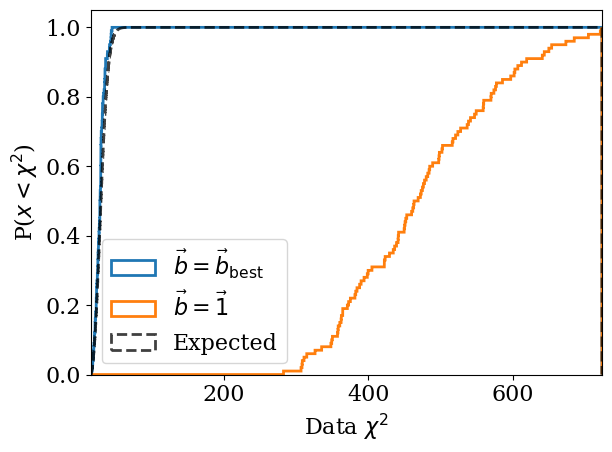

Error Inflation b=b_best: 0.97227
Error Inflation b=1: 3.91269


In [17]:
lw = 2
alpha = 1.0
cumulative = True

df = n_reads-2
err_inflate_with_b = stats.chi2.fit(chi2s_data_with_b,fdf=df,floc=0)[2]**0.5
err_inflate_no_b = stats.chi2.fit(chi2s_data_no_b,fdf=df,floc=0)[2]**0.5

hist_range = [min(np.min(chi2s_data_with_b),np.min(chi2s_data_no_b)),\
              max(np.max(chi2s_data_with_b),np.max(chi2s_data_no_b))]

hist = plt.hist(chi2s_data_with_b,
         histtype='step',cumulative=cumulative,
         density=True,bins=10000,range=hist_range,
         label=r'$\vec b = \vec b_{\mathrm{best}}$',
         lw=lw,alpha=alpha)
hist_bins = hist[1]
hist_bin_centers = 0.5*(hist_bins[1:]+hist_bins[:-1])

plt.hist(chi2s_data_no_b,
         histtype='step',cumulative=cumulative,
         density=True,bins=10000,range=hist_range,
         label=r'$\vec b = \vec 1$',
         lw=lw,alpha=alpha)
expect_weights = np.diff(stats.chi2(loc=0,scale=1,df=df).cdf(hist_bins))
expect_weights /= np.sum(expect_weights)
plt.hist(hist_bin_centers,weights=expect_weights,histtype='step',
         density=True,bins=hist_bins,cumulative=cumulative,color='k',
        label='Expected',lw=lw,alpha=0.75,ls='--')
leg = plt.legend(loc='best')
plt.xlim(hist_range[0],hist_range[1])
plt.xlabel('Data $\chi^2$')
plt.ylabel('P($x < \chi^2$)')
plt.tight_layout()
plt.savefig(f'{plotpath}single_fit_data_chi2.png')
plt.show()

print('Error Inflation b=b_best:',np.round(err_inflate_with_b,5))
print('Error Inflation b=1:',np.round(err_inflate_no_b,5))


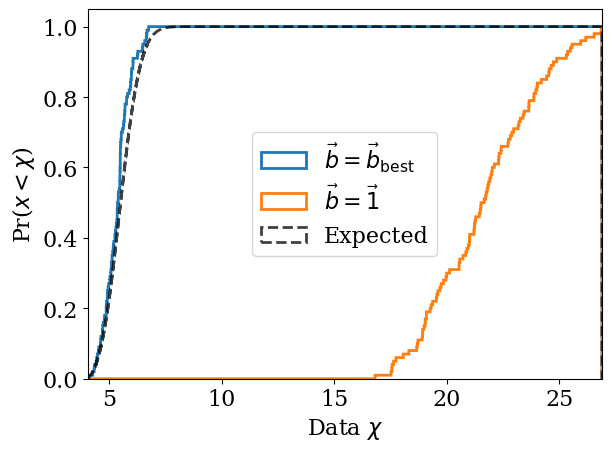

Error Inflation b=b_best: 0.97227
Error Inflation b=1: 3.9127


In [18]:
lw = 2
alpha = 1.0
cumulative = True

df = n_reads-2
err_inflate_with_b = stats.chi.fit(np.sqrt(chi2s_data_with_b),fdf=df,floc=0)[2]
err_inflate_no_b = stats.chi.fit(np.sqrt(chi2s_data_no_b),fdf=df,floc=0)[2]

hist_range = [min(np.min(chi2s_data_with_b),np.min(chi2s_data_no_b)),\
              max(np.max(chi2s_data_with_b),np.max(chi2s_data_no_b))]
hist_range = np.sqrt(np.array(hist_range))

hist = plt.hist(np.sqrt(chi2s_data_with_b),
         histtype='step',cumulative=cumulative,
         density=True,bins=10000,range=hist_range,
         label=r'$\vec b = \vec b_{\mathrm{best}}$',
         lw=lw,alpha=alpha)
hist_bins = hist[1]
hist_bin_centers = 0.5*(hist_bins[1:]+hist_bins[:-1])

plt.hist(np.sqrt(chi2s_data_no_b),
         histtype='step',cumulative=cumulative,
         density=True,bins=10000,range=hist_range,
         label=r'$\vec b = \vec 1$',
         lw=lw,alpha=alpha)
expect_weights = np.diff(stats.chi(loc=0,scale=1,df=df).cdf(hist_bins))
expect_weights /= np.sum(expect_weights)
plt.hist(hist_bin_centers,weights=expect_weights,histtype='step',
         density=True,bins=hist_bins,cumulative=cumulative,color='k',
        label='Expected',lw=lw,alpha=0.75,ls='--')
leg = plt.legend(loc='best')
plt.xlabel('Data $\chi$')
plt.ylabel('Pr($x < \chi$)')
plt.xlim(hist_range[0],hist_range[1])
plt.tight_layout()
plt.savefig(f'{plotpath}single_fit_data_chi.png')
plt.show()

print('Error Inflation b=b_best:',np.round(err_inflate_with_b,5))
print('Error Inflation b=1:',np.round(err_inflate_no_b,5))


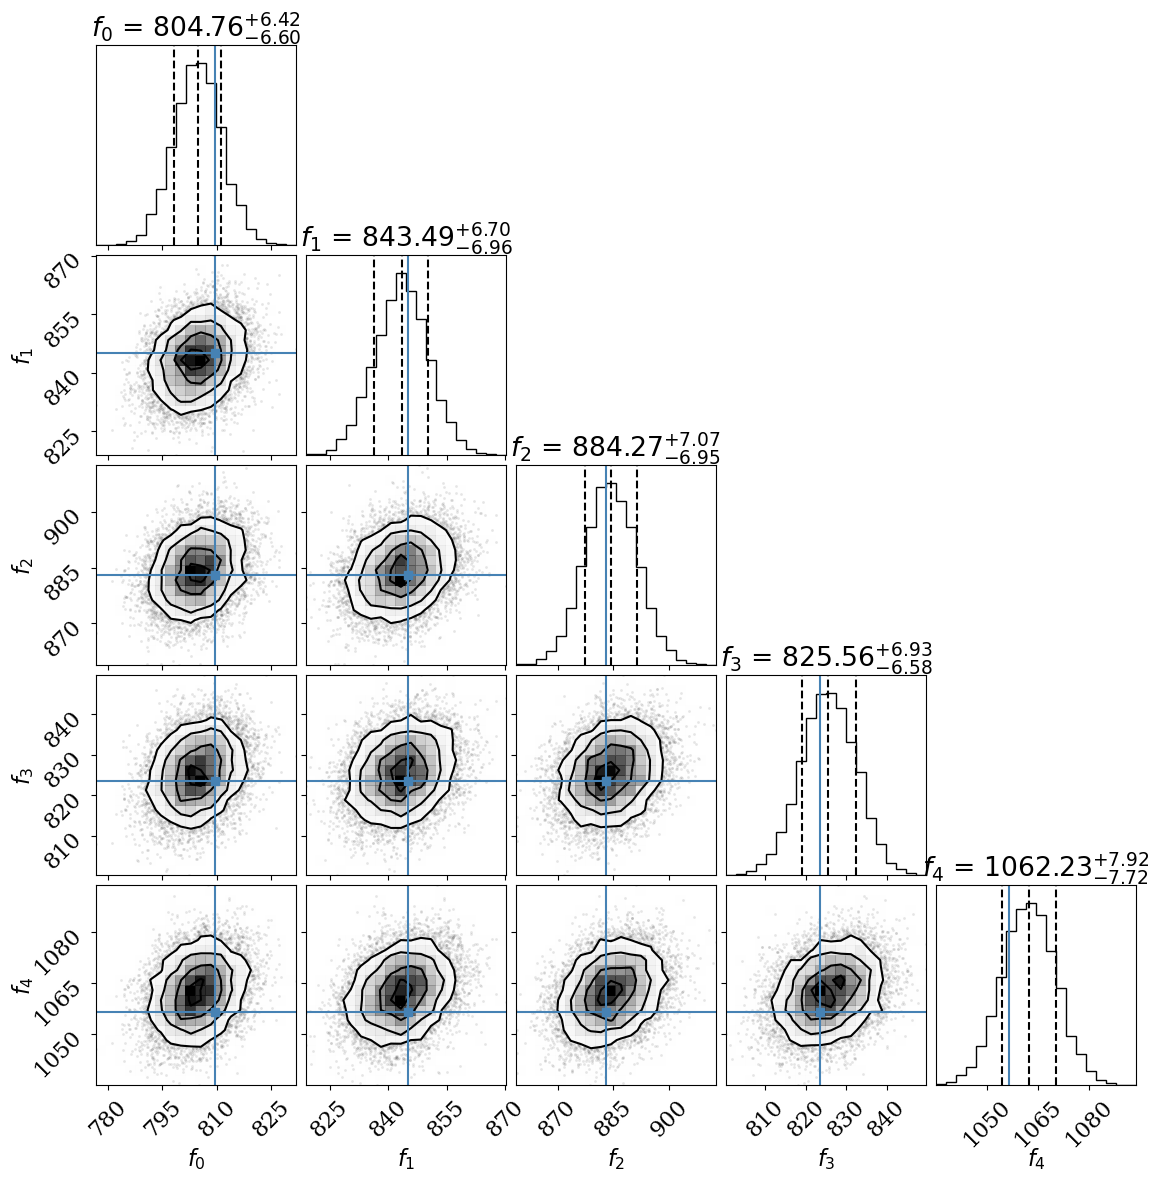

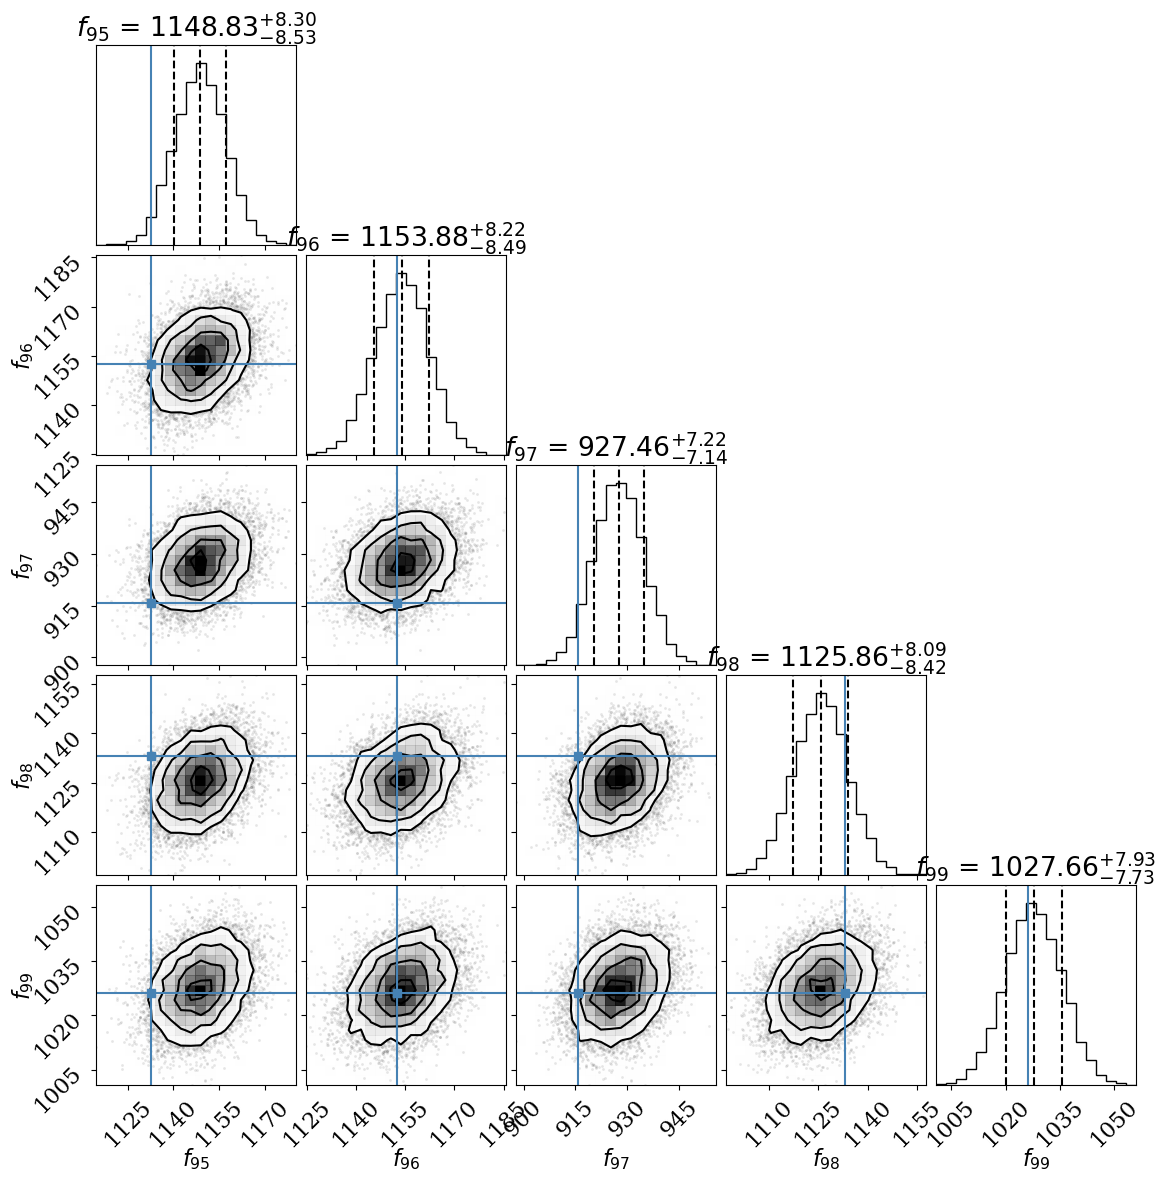

In [19]:
#f vector plots


plot_inds = np.arange(0,5).astype(int)
labels = []
for plot_ind in plot_inds:
    labels.append('$f_{%d}$'%plot_ind)
corner.corner(comb_param_samps[:,plot_inds],
              show_titles=True,quantiles=[0.16,0.50,0.84],
              truths=true_param_means[plot_inds],labels=labels,
              fontsize=14)
plt.show()
plot_inds = np.arange(-5,0).astype(int)+n_pixels
labels = []
for plot_ind in plot_inds:
    labels.append('$f_{%d}$'%plot_ind)
corner.corner(comb_param_samps[:,plot_inds],
              show_titles=True,quantiles=[0.16,0.50,0.84],
              truths=true_param_means[plot_inds],labels=labels)
plt.show()

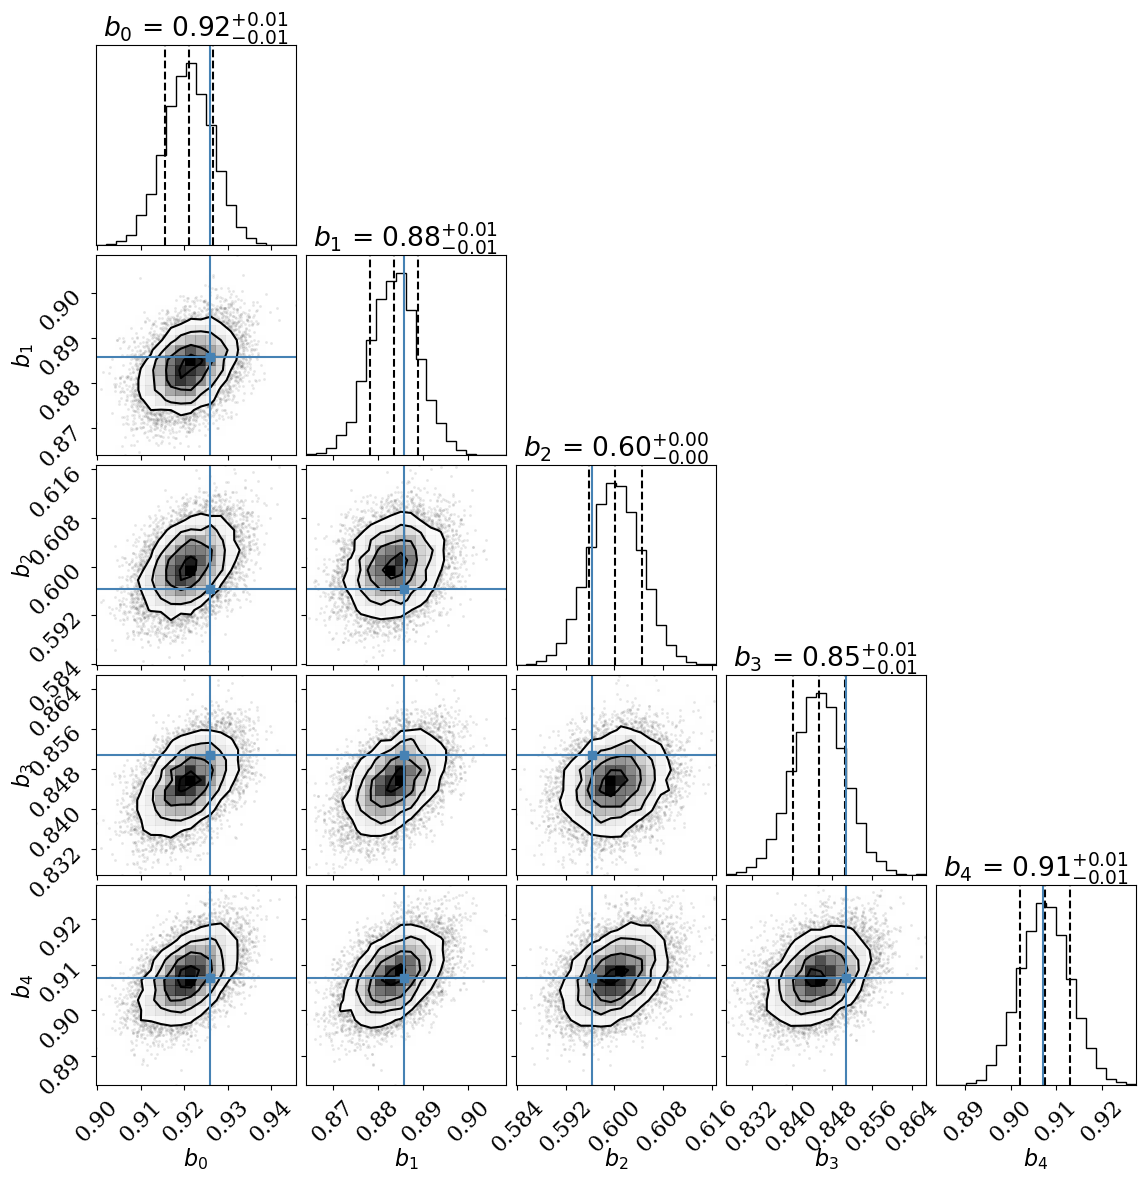

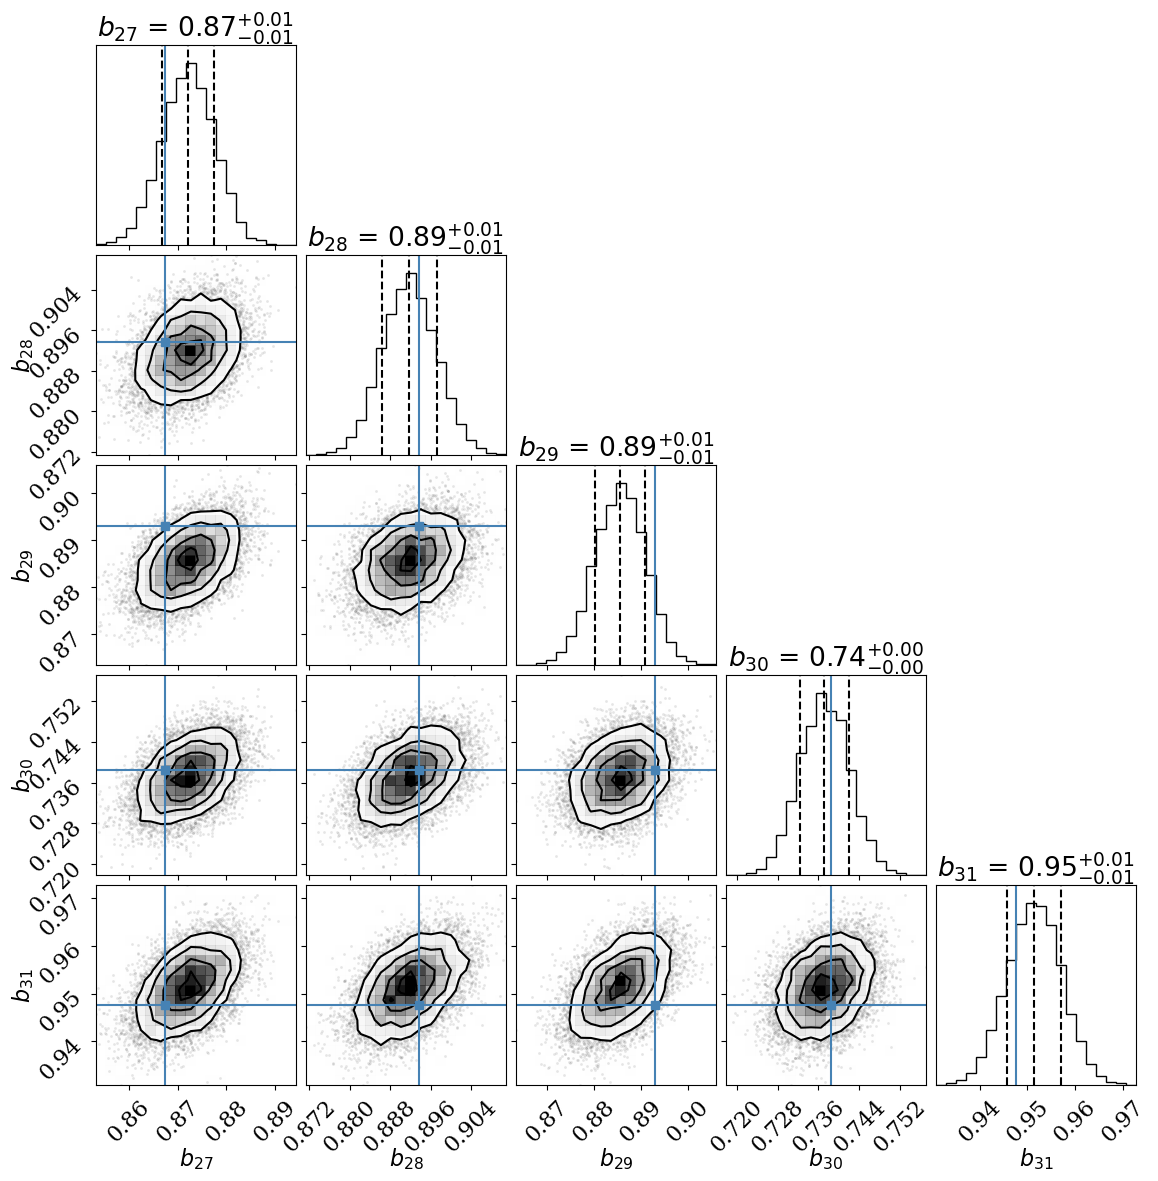

In [20]:
#b vector plots

plot_inds = np.arange(0,5).astype(int)+n_pixels
labels = []
for plot_ind in plot_inds:
    labels.append('$b_{%d}$'%non_max_inds[plot_ind-n_pixels])
corner.corner(comb_param_samps[:,plot_inds],
              show_titles=True,quantiles=[0.16,0.50,0.84],
              truths=true_param_means[plot_inds],labels=labels)
plt.show()
plot_inds = non_max_inds[-5:]+n_pixels-1
labels = []
for plot_ind in plot_inds:
    labels.append('$b_{%d}$'%non_max_inds[plot_ind-n_pixels])

corner.corner(comb_param_samps[:,plot_inds],
              show_titles=True,quantiles=[0.16,0.50,0.84],
              truths=true_param_means[plot_inds],labels=labels)
plt.show()

[28 30]


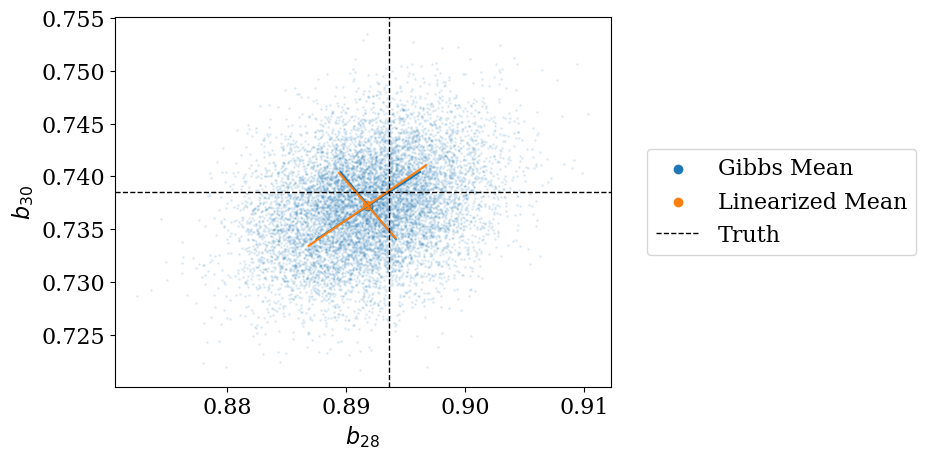

In [21]:
b_inds = np.array([0,1])
b_inds = np.array([28,30])-1
# b_inds = np.array([36,37])-1
orig_b_inds = non_max_inds[b_inds]
comb_inds = b_inds+n_pixels
true_param_means

print(orig_b_inds)

plt.scatter(comb_param_samps_gibbs[:,comb_inds[0]],
            comb_param_samps_gibbs[:,comb_inds[1]],
            s=1,alpha=0.1)
# plt.scatter(comb_param_samps_linear[:,comb_inds[0]],
#             comb_param_samps_linear[:,comb_inds[1]],
#             s=1,alpha=0.1)

curr_med = b_vect_mean_gibbs[orig_b_inds]
curr_cov = np.zeros((2,2))
curr_cov[0,0] = b_vect_cov_gibbs[orig_b_inds[0],orig_b_inds[0]]
curr_cov[0,1] = b_vect_cov_gibbs[orig_b_inds[0],orig_b_inds[1]]
curr_cov[1,0] = b_vect_cov_gibbs[orig_b_inds[1],orig_b_inds[0]]
curr_cov[1,1] = b_vect_cov_gibbs[orig_b_inds[1],orig_b_inds[1]]
curr_vals,curr_vects = np.linalg.eig(curr_cov)
curr_vals = np.sqrt(curr_vals)
err_vects = np.zeros_like(curr_vects)
err_vects[0] = curr_vals[0]*curr_vects[:,0]
err_vects[1] = curr_vals[1]*curr_vects[:,1]    

err1_plot = [curr_med[0]-err_vects[0,0],curr_med[0]+err_vects[0,0]],\
            [curr_med[1]-err_vects[0,1],curr_med[1]+err_vects[0,1]]
err2_plot = [curr_med[0]-err_vects[1,0],curr_med[0]+err_vects[1,0]],\
            [curr_med[1]-err_vects[1,1],curr_med[1]+err_vects[1,1]]
color = 'C0'
plt.scatter(curr_med[0],curr_med[1],
            marker='o',label='Gibbs Mean',color=color)
plt.plot(err1_plot[0],err1_plot[1],color=color)
plt.plot(err2_plot[0],err2_plot[1],color=color)

curr_med = b_vect_mean_linear[orig_b_inds]
curr_cov = np.zeros((2,2))
curr_cov[0,0] = b_vect_cov_linear[orig_b_inds[0],orig_b_inds[0]]
curr_cov[0,1] = b_vect_cov_linear[orig_b_inds[0],orig_b_inds[1]]
curr_cov[1,0] = b_vect_cov_linear[orig_b_inds[1],orig_b_inds[0]]
curr_cov[1,1] = b_vect_cov_linear[orig_b_inds[1],orig_b_inds[1]]
curr_vals,curr_vects = np.linalg.eig(curr_cov)
curr_vals = np.sqrt(curr_vals)
err_vects = np.zeros_like(curr_vects)
err_vects[0] = curr_vals[0]*curr_vects[:,0]
err_vects[1] = curr_vals[1]*curr_vects[:,1]    

err1_plot = [curr_med[0]-err_vects[0,0],curr_med[0]+err_vects[0,0]],\
            [curr_med[1]-err_vects[0,1],curr_med[1]+err_vects[0,1]]
err2_plot = [curr_med[0]-err_vects[1,0],curr_med[0]+err_vects[1,0]],\
            [curr_med[1]-err_vects[1,1],curr_med[1]+err_vects[1,1]]
color = 'C1'
plt.scatter(curr_med[0],curr_med[1],
            marker='o',label='Linearized Mean',color=color)
plt.plot(err1_plot[0],err1_plot[1],color=color)
plt.plot(err2_plot[0],err2_plot[1],color=color)

# plt.errorbar(b_vect_mean_gibbs[orig_b_inds[0]],b_vect_mean_gibbs[orig_b_inds[1]],
#              xerr=b_vect_errs_gibbs[orig_b_inds[0]],
#              yerr=b_vect_errs_gibbs[orig_b_inds[1]],
#              fmt='o',label='Gibbs Mean')
# plt.errorbar(b_vect_mean_linear[orig_b_inds[0]],b_vect_mean_linear[orig_b_inds[1]],
#              xerr=b_vect_errs_linear[orig_b_inds[0]],
#              yerr=b_vect_errs_linear[orig_b_inds[1]],
#              fmt='o',label='Linearized Mean')
plt.axhline(true_param_means[comb_inds[1]],c='k',lw=1,ls='--',label='Truth')
plt.axvline(true_param_means[comb_inds[0]],c='k',lw=1,ls='--')
plt.xlabel('$b_{%d}$'%orig_b_inds[0])
plt.ylabel('$b_{%d}$'%orig_b_inds[1])
plt.legend(loc=6,bbox_to_anchor=(1.05,0.5))
plt.show()
